In [26]:
from math import sqrt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GRU
from tensorflow.keras.losses import mean_squared_error
from numpy.core._multiarray_umath import concatenate
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Layer
from keras import backend as K


# supervised监督学习函数
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if isinstance(data, list) else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (columns[j], j + 1, i))
                  for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (columns[j], j + 1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (columns[j], j + 1, i))
                      for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg
    # return agg


dataset = pd.read_csv(
    'Machine_usage_groupby.csv')

dataset_columns = dataset.columns
values = dataset.values
print(dataset)

# 归一化处理
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# 监督学习
reframed = series_to_supervised(scaled, dataset_columns, 1, 1)
values = reframed.values

# 学习与检测数据的划分
n_train_hours = 40000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


# 监督学习结果划分
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# 为了在LSTM中应用该数据，需要将其格式转化为3D format，即[Samples, timesteps, features]
train_X = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_X = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

         Time  cpu_util_percent  ...  net_out  disk_usage_percent
0           0           16.1270  ...  27.6575              4.0867
1          10           21.5878  ...  27.6564              4.0425
2          20           17.3193  ...  27.6266              4.0546
3          30           16.8287  ...  27.6489              4.0620
4          40           18.6518  ...  27.6149              4.0390
...       ...               ...  ...      ...                 ...
67237  691150           39.1515  ...  37.6852              4.8983
67238  691160           37.5635  ...  37.8032              4.8968
67239  691170           36.3224  ...  37.7655              4.8918
67240  691180           36.4804  ...  37.7900              4.9139
67241  691190           37.1939  ...  37.7631              4.8518

[67242 rows x 6 columns]


In [27]:
model = Sequential()
model.add(
    GRU(
        32,
        input_shape=(
            train_X.shape[1],
            train_X.shape[2]),
        return_sequences=True))
model.add(GRU(16, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(loss=tf.keras.losses.Huber(),
    optimizer='adam',
    metrics=["mse"])
history = model.fit(
    train_X,
    train_y,
    epochs=50,
    batch_size=72,
    validation_data=(
        test_X,
        test_y),
verbose = 2)


Epoch 1/50
556/556 - 3s - loss: 0.0014 - mse: 0.0028 - val_loss: 3.2507e-04 - val_mse: 6.5015e-04
Epoch 2/50
556/556 - 3s - loss: 3.6658e-04 - mse: 7.3316e-04 - val_loss: 3.2163e-04 - val_mse: 6.4325e-04
Epoch 3/50
556/556 - 3s - loss: 3.5854e-04 - mse: 7.1707e-04 - val_loss: 3.5201e-04 - val_mse: 7.0403e-04
Epoch 4/50
556/556 - 3s - loss: 3.5896e-04 - mse: 7.1792e-04 - val_loss: 3.2470e-04 - val_mse: 6.4941e-04
Epoch 5/50
556/556 - 3s - loss: 3.6157e-04 - mse: 7.2315e-04 - val_loss: 5.8063e-04 - val_mse: 0.0012
Epoch 6/50
556/556 - 3s - loss: 3.5505e-04 - mse: 7.1010e-04 - val_loss: 5.1353e-04 - val_mse: 0.0010
Epoch 7/50
556/556 - 3s - loss: 3.5765e-04 - mse: 7.1530e-04 - val_loss: 3.2050e-04 - val_mse: 6.4100e-04
Epoch 8/50
556/556 - 3s - loss: 3.5356e-04 - mse: 7.0711e-04 - val_loss: 3.5661e-04 - val_mse: 7.1321e-04
Epoch 9/50
556/556 - 3s - loss: 3.5443e-04 - mse: 7.0886e-04 - val_loss: 3.2308e-04 - val_mse: 6.4616e-04
Epoch 10/50
556/556 - 3s - loss: 3.5660e-04 - mse: 7.1320e-04 

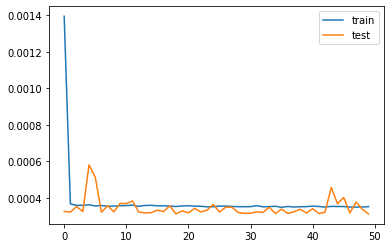

Errors:  [-0.002938259748555591, -0.011809567514136018, -0.004195025715305986, -0.004063250086677031, -0.004041416203184586, -0.004609999765048264, -0.004087850971769738, 0.003273078287190076, -0.00347708207788662, -0.0032131275601012116, -0.0013888040247616723, -0.0032699848677017612, -0.004145977036288315, -0.052554255552854076, -0.008238602626763555, -0.008286731524795463, -0.006510541516185228, -0.007452609224647452, -0.006935450459155237, 0.015570713479818407, -0.003731653886772504, -0.008021526693697614, -0.007060221620491622, -0.007371704361163786, -0.008563828375452512, 0.007590147010288553, -0.0045957106617770666, -0.00491586673586121, -0.004857606920883564, -0.004791671149540613, -0.005731541398451237, -0.024665516542847307, -0.00796410784300898, -0.007854983378883726, -0.009242509660777512, -0.008010947779145142, -0.006027538489093584, -0.007840920250535302, -0.0038789822968051807, -9.455862140093918e-05, -0.00077422710789328, -0.005019518126662473, -0.006532990858412149, -0

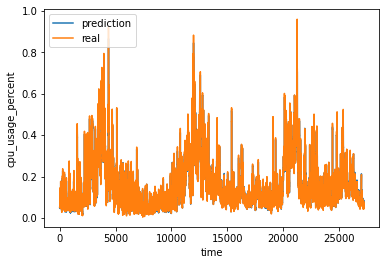

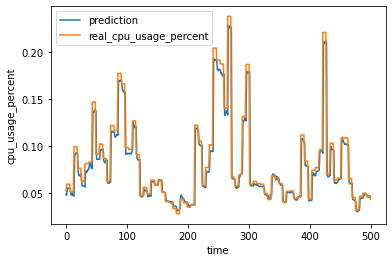

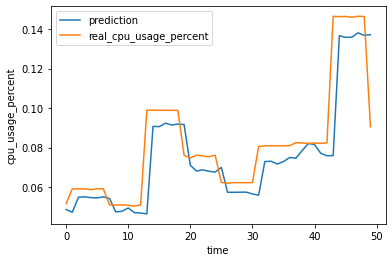

In [28]:
#画图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make the prediction
yHat = model.predict(test_X)

inv_yHat = concatenate((yHat, test_x[:, 1:]), axis=1)   # 数组拼接
inv_yHat = inv_yHat[:, 0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_x[:, 1:]), axis=1)
inv_y = inv_y[:, 0]

target = inv_yHat
prediction = inv_y
error = []
for i in range(len(target)):
    error.append(target[i] - prediction[i])

print("Errors: ",error)
print(error)

squaredError = []
absError = []
for val in error:
    squaredError.append(val * val)  # target-prediction之差平方
    absError.append(abs(val))  # 误差绝对值

print("Square Error: ",squaredError)
print("Absolute Value of Error: ",absError)

print("MSE = ",sum(squaredError) / len(squaredError))  # 均方误差MSE

yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = concatenate((yhat, yhat, test_X_reshaped[:, 1:]), axis=1)
inv_yhat = inv_yhat[:, 0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_y, test_X_reshaped[:, 1:]), axis=1)
inv_y = inv_y[:, 0]
plt.plot(inv_yhat, label='prediction')
plt.plot(inv_y, label='real')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()

plt.plot(inv_yhat[:500], label='prediction')
plt.plot(inv_y[:500], label='real_cpu_usage_percent')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()

plt.plot(inv_yhat[:50], label='prediction')
plt.plot(inv_y[:50], label='real_cpu_usage_percent')
plt.xlabel('time')
plt.ylabel('cpu_usage_percent')
plt.legend()
plt.show()